# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [1]:
# ! pip install git+https://github.com/openai/whisper.git

In [2]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

# Loading the Fleurs dataset

Select the language of the Fleur dataset to download. Please note that the transcription and translation performance varies widely depending on the language. Appendix D.2 in the paper contains the performance breakdown by language.

In [3]:
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="cmn_hans_cn",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=13, options=(('Select language', None), ('----------', None), ('Afrika…

In [4]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: Chinese (cmn_hans_cn)


In [5]:
def download(url: str, target_path: str):
    with urllib.request.urlopen(url) as source, open(target_path, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))


class Fleurs(torch.utils.data.Dataset):
    """
    A simple class to wrap Fleurs and subsample a portion of the dataset as needed.
    """
    def __init__(self, lang, split="test", subsample_rate=1, device=DEVICE):
        url = f"https://storage.googleapis.com/xtreme_translations/FLEURS102/{lang}.tar.gz"
        tar_path = os.path.expanduser(f"~/.cache/fleurs/{lang}.tgz")
        os.makedirs(os.path.dirname(tar_path), exist_ok=True)

        if not os.path.exists(tar_path):
            download(url, tar_path)

        all_audio = {}
        with tarfile.open(tar_path, "r:gz") as tar:
            for member in tar.getmembers():
                name = member.name
                if name.endswith(f"{split}.tsv"):
                    labels = pd.read_table(tar.extractfile(member), names=("id", "file_name", "raw_transcription", "transcription", "_", "num_samples", "gender"))

                if f"/{split}/" in name and name.endswith(".wav"):
                    audio_bytes = tar.extractfile(member).read()
                    all_audio[os.path.basename(name)] = wavfile.read(io.BytesIO(audio_bytes))[1]                    

        self.labels = labels.to_dict("records")[::subsample_rate]
        self.all_audio = all_audio
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        record = self.labels[item]
        audio = torch.from_numpy(self.all_audio[record["file_name"]].copy())
        text = record["transcription"]
        
        return (audio, text)

In [6]:
dataset = Fleurs(lang, subsample_rate=10)  # subsample 10% of the dataset for a quick demo

  0%|                                              | 0.00/2.35G [00:00<?, ?iB/s]

# Running inference on the dataset using a medium Whisper model

The following will take a few minutes to transcribe and translate utterances in the dataset.

In [7]:
model = whisper.load_model("base")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 71,825,920 parameters.


In [8]:
options = dict(language=language, beam_size=5, best_of=5)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [9]:
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

  0%|          | 0/95 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/langchain/lib/python3.11/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [10]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data

reference  \
0                                                                                                               特朗普与土耳其总统雷杰普·塔伊普·埃尔多安recep tayyip erdoğan通话后发表了声明   
1                                                                                     他 受 到 了 新 加 坡 副 总 理 黄 根 成 的 欢 迎 并 与 新 加 坡 总 理 李 显 龙 探 讨 了 贸 易 和 恐 怖 主 义 问 题   
2                                                               虽 然 有 一 种 实 验 性 疫 苗 看 似 能 够 降 低 埃 博 拉 病 毒 的 死 亡 率 但 迄 今 为 止 还 没 明 确 证 明 任 何 药 物 适 合 治 疗 现 有 的 感 染   
3                                                                                                                             场 景 在 金 字 塔 上 展 示 不 同 的 金 字 塔 被 点 亮   
4                                                                                     同 理 有 了 申 根 签 证 你 就 不 必 分 别 向 每 个 申 根 成 员 国 申 请 签 证 从 而 节 省 了 时 间 金 钱 和 手 续   
5                                                          昨 日 上 午 土 耳 其 加 齐 安 泰 普 gaziantep 的 警 察 总 部 发 生 了 一 起 汽 车 炸 弹 爆 炸 事 件 该 事 件 导 致 两 名 警 察 死 亡 20 余 人 受 伤   
6                                                                                                                               州 长 办 公 室 表 示 伤 者 中 有 十 九 人 是 警 察   
7                                                                                                           文 明 是 一 种 由 共 同 生 活 合 作 工 作 的 人 群 社 会 所 共 享 的 单 一 文 化   
8                                                                                                                 随 着 希 腊 知 识 的 衰 落 西 方 脱 离 了 其 希 腊 哲 学 和 科 学 根 源   
9                                                               早 年 该 节 目 仅 在 运 营 已 久 的 互 联 网 广 播 网 站 toginet radio 上 播 出 toginet radio 是 一 个 专 注 于 谈 话 广 播 的 网 站   
10                                 在 由 茅 茅 运 动 为 争 取 独 立 而 组 织 发 起 的 斗 争 中 该 镇 的 一 场 和 平 集 会 致 使 大 酋 长 图 普 阿 塔 马 塞 塞 利 罗 菲 三 世 tupua tamasese lealofi iii 遇 害 身 亡   
11                                                                                支 架 式 教 学 不 是 一 种 学 习 方 法 而 是 一 种 辅 助 刚 学 习 使 用 新 电 脑 程 序 或 启 动 新 项 目 的 人 的 手 段   
12                                                                                                                 1990 年 由 于 沙 漠 的 威 胁 它 被 列 入 了 濒 危 世 界 遗 产 名 录   
13                                                                                  有 些 原 子 含 有 不 稳 定 的 原 子 核 这 意 味 着 它 们 很 可 能 会 在 很 少 或 没 有 刺 激 的 情 况 下 发 生 分 裂   
14              29 岁 的 malar balasubramanian 医 生 在 俄 亥 俄 州 辛 辛 那 提 市 以 北 约 15 英 里 的 郊 区 布 鲁 艾 施 被 发 现 她 被 找 到 时 身 穿 t 恤 衫 和 内 裤 躺 在 路 边 的 地 上 看 上 去 服 用 了 大 量 药 物   
15                                                                                                          山 羊 似 乎 是 1 万 年 前 左 右 在 伊 朗 的 扎 格 罗 斯 山 脉 首 次 被 驯 养 的   
16                                                                                    如 果 你 不 习 惯 在 乡 村 道 路 上 开 车 那 可 要 保 持 头 脑 清 醒 这 里 到 处 都 是 陡 坡 窄 车 道 和 急 转 弯   
17                                                                                                                        很 多 人 认 为 它 们 并 非 恐 龙 因 为 它 们 有 羽 毛 会 飞   
18                                                                                                              起 初 他 被 送 往 位 于 大 雅 茅 斯 的 詹 姆 斯 佩 吉 特 医 院 进 行 救 治   
19                                                                           例 如 世 界 上 最 常 见 的 静 态 图 像 摄 影 格 式 是 35mm 格 式 这 是 胶 片 电 影 时 代 末 期 占 主 导 地 位 的 电 影 尺 寸   
20                                                                                 虽然这通常只是一种不准确的刻板印象但在巴黎生活的最佳方式仍然是尽量举止得当表现得像一个有  bien élevé”教养良好的人这会让参加社会活动变得容易得多   
21                                                                                                尽 管 如 此 还 是 要 听 从 有 关 部 门 的 建 议 遵 守 所 有 的 标 志 并 密 切 注 意 安 全 警 告   
22                                                                                                      山 区 夏 令 时 晚 上 10 点 到 11 点 之 间 院 子 里 的 犯 人 们 引 发 了 一 场 火 灾   
23                                                                            除 了 清 澈 美 丽 的 天 空 和 周 围 的 群 山 什 么 也 看 不 见 在 洞 穴 中 几 乎 看 不 到 也 听 不 到 外 界 的 景 象 和 声 音   
24                        巴

# Word-level timestamps using attention weights

Below, we use the cross-attention weights to determine more granular, word-level timestamps. It uses a set of heuristics and dynamic time warping (DTW) to find the alignment between the audio and the transcript.

In [11]:
! pip install dtw-python

In [12]:
import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [13]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(model.is_multilingual, language=languages[lang])

In [14]:
# This part downloads a repackaged version of the Noto Sans font (either CJK or non-CJK)
# to render various languages in Matplotlib figures.

if languages[lang] in {"Chinese", "Japanese", "Korean"}:
    font = "GoNotoCJKCore.ttf"
else:
    font = "GoNotoCurrent.ttf"

font_release = "https://github.com/satbyy/go-noto-universal/releases/download/v5.2"
if not os.path.exists(font):
    download(f"{font_release}/{font}", font)

prop = fm.FontProperties(fname=font)
props = {'fontproperties': prop}

In [15]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []
    
    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []
    
    return words, word_tokens

In [16]:
def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []
    
    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)
    
    return words, word_tokens

In [17]:
if languages[lang] in {"Chinese", "Japanese", "Thai", "Lao", "Myanmar"}:
    # These languages don't typically use spaces, so it is difficult to split words
    # without morpheme analysis. Here, we instead split words at any
    # position where the tokens are decoded as valid unicode points
    split_tokens = split_tokens_on_unicode
else:
    split_tokens = split_tokens_on_spaces

In [18]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

特朗普與土耳其總統雷傑普、塔伊普艾爾端通話後發表了聲明


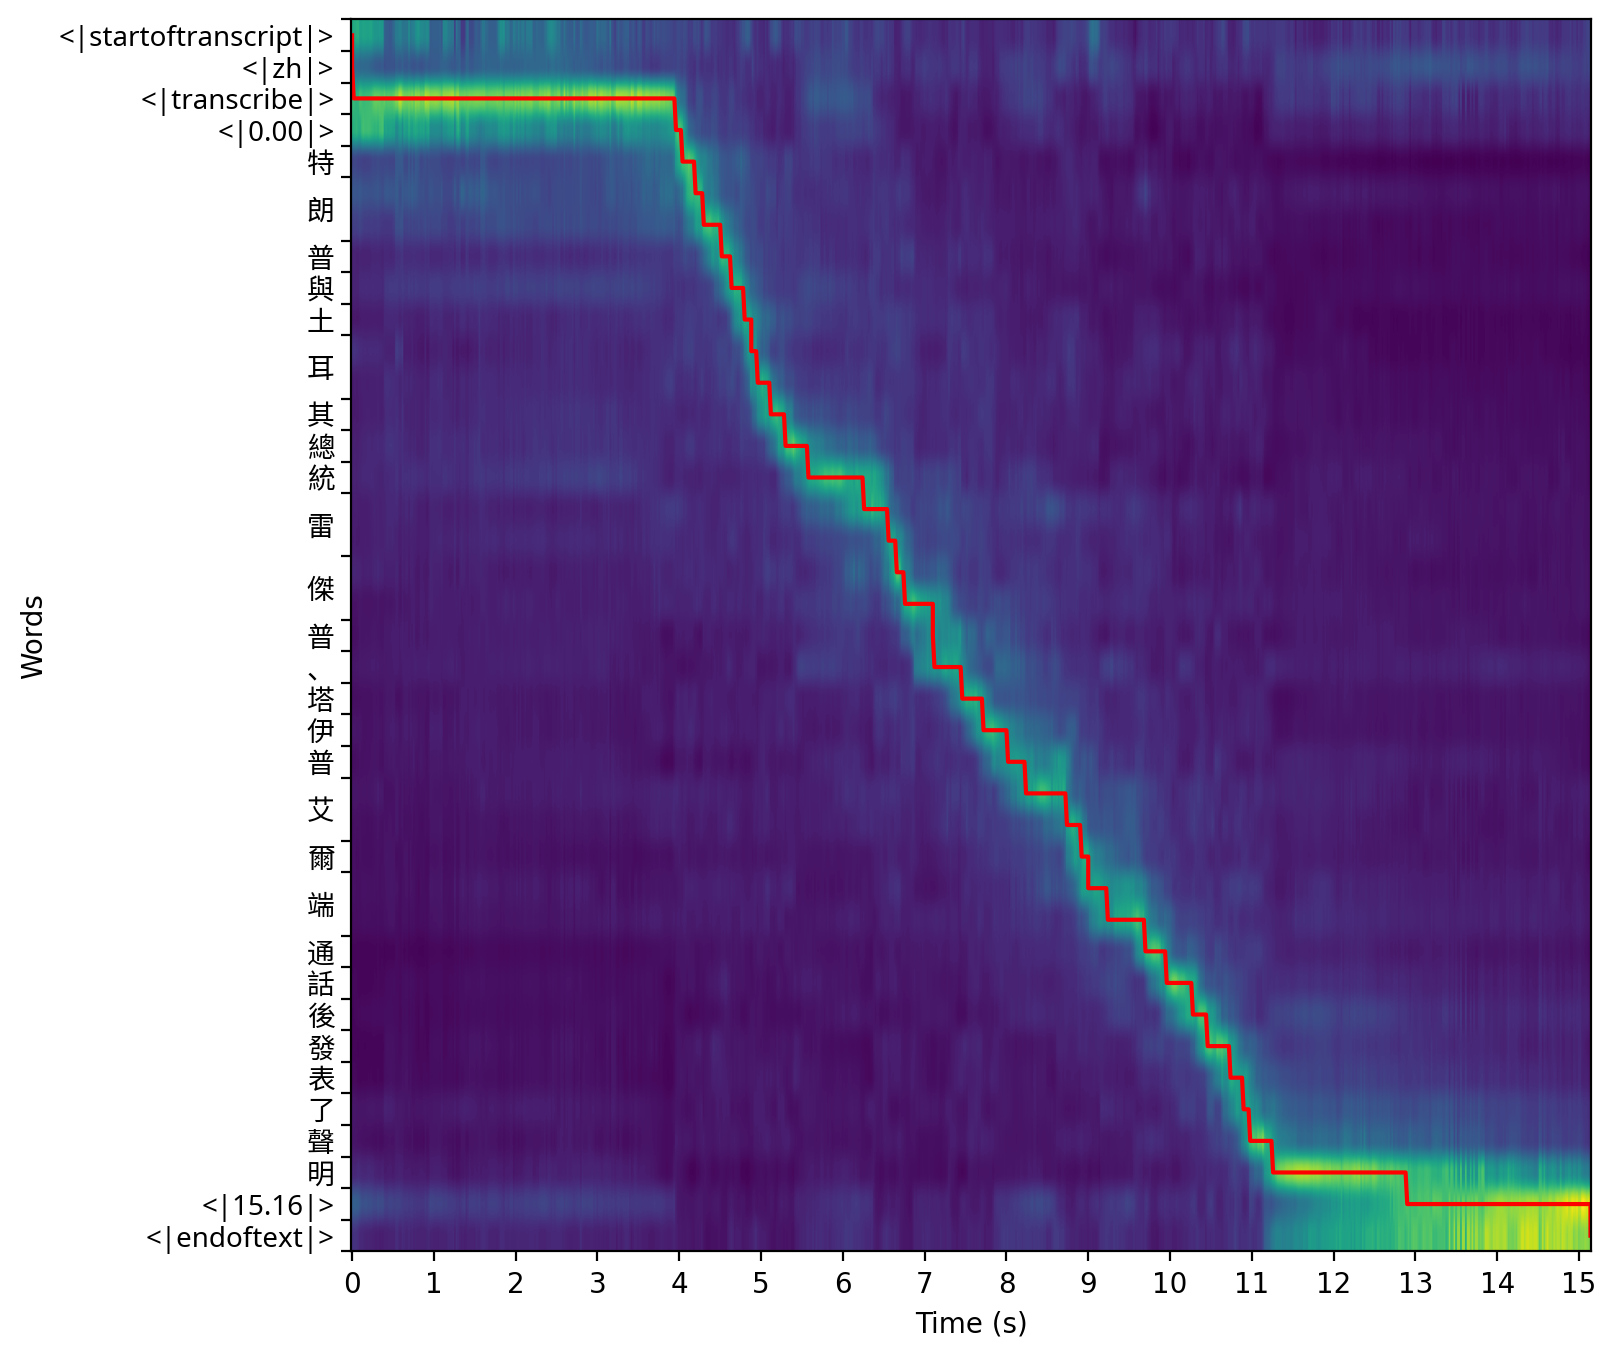

word  begin    end
0     特   4.04   4.20
1     朗   4.20   4.52
2     普   4.52   4.64
3     與   4.64   4.80
4     土   4.80   4.88
5     耳   4.88   5.12
6     其   5.12   5.30
7     總   5.30   5.58
8     統   5.58   6.26
9     雷   6.26   6.66
10    傑   6.66   7.10
11    普   7.10   7.12
12    塔   7.46   7.72
13    伊   7.72   8.02
14    普   8.02   8.24
15    艾   8.24   8.92
16    爾   8.92   9.00
17    端   9.00   9.70
18    通   9.70   9.96
19    話   9.96  10.28
20    後  10.28  10.46
21    發  10.46  10.74
22    表  10.74  10.90
23    了  10.90  10.98
24    聲  10.98  11.26
25    明  11.26  12.90

大受到了新加坡副總理黃根誠的歡迎,並與新加坡總理李顯龍探討了貿易和恐怖主義問題。


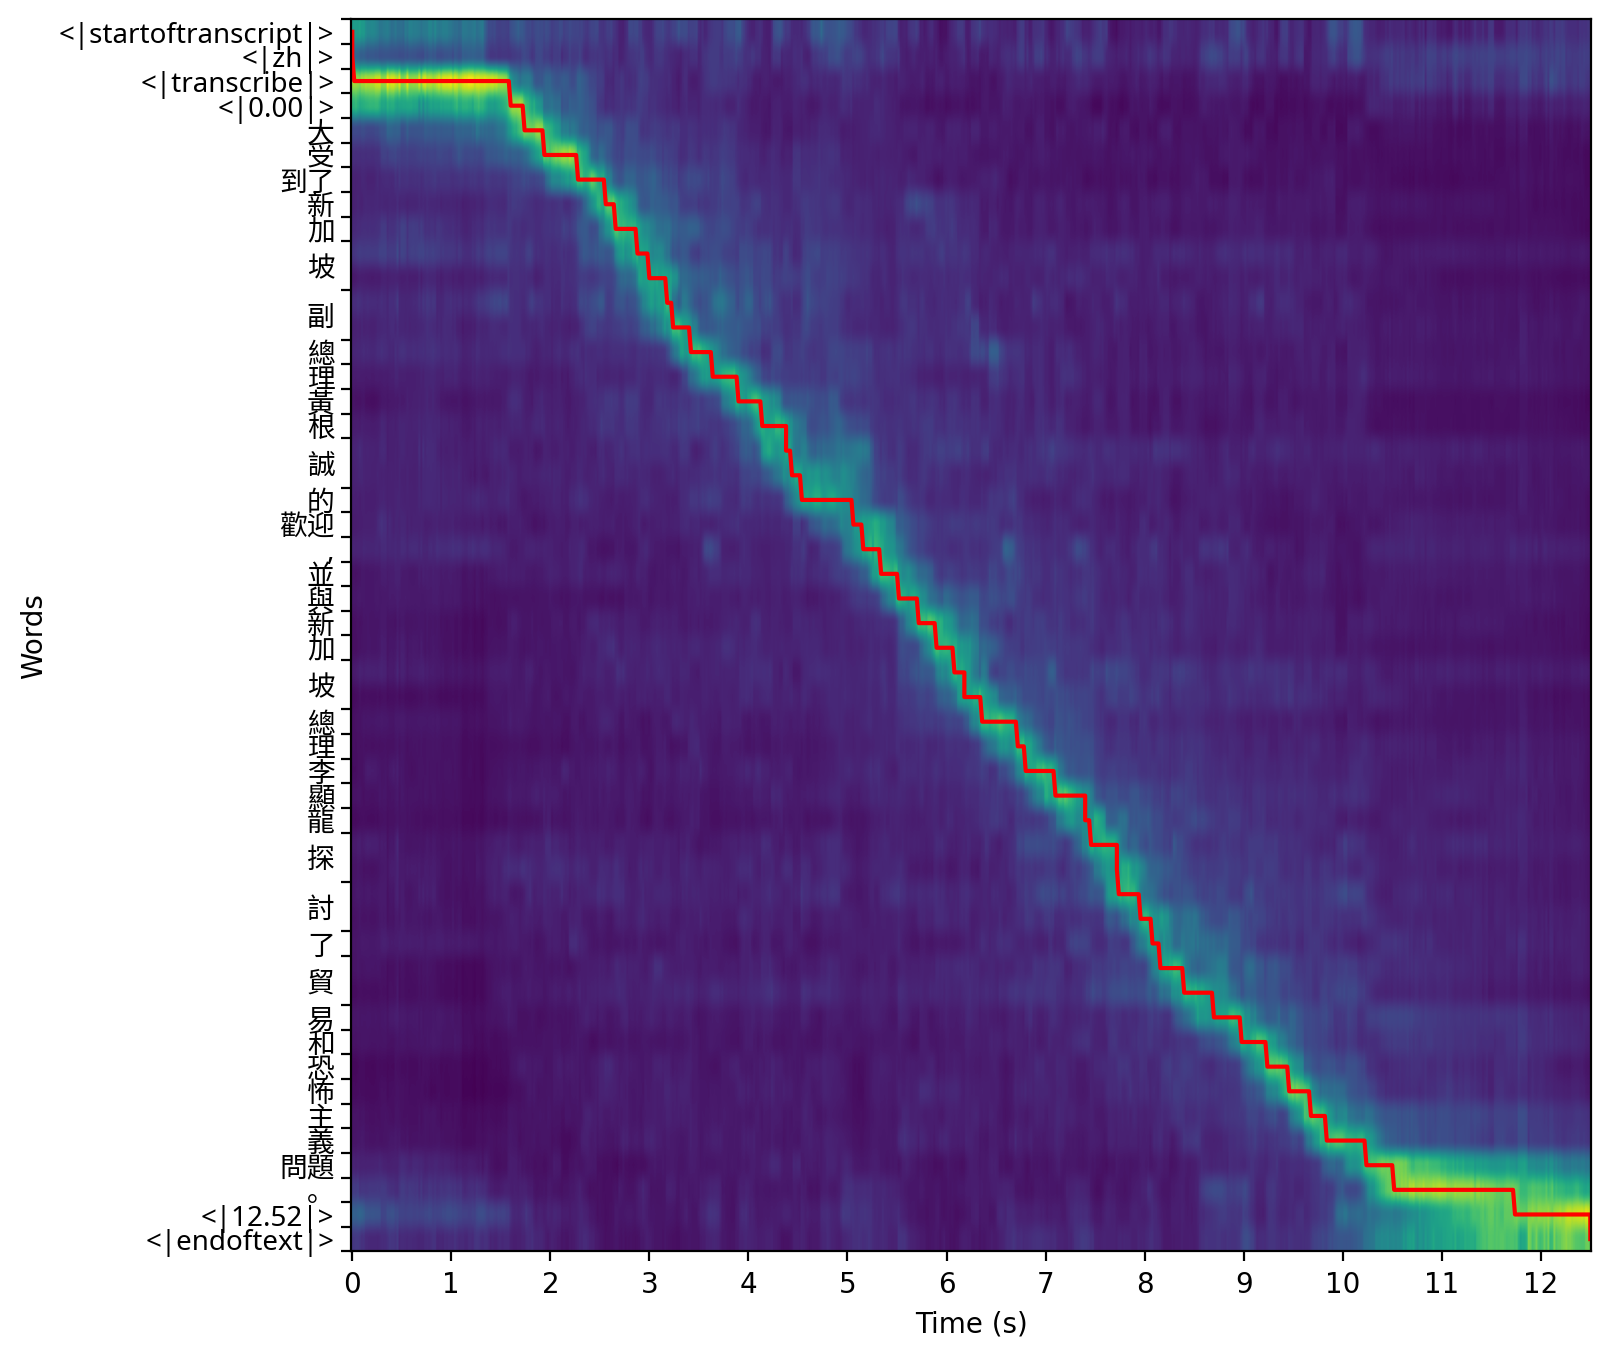

word  begin    end
0     大   1.74   1.94
1     受   1.94   2.28
2    到了   2.28   2.56
3     新   2.56   2.66
4     加   2.66   2.88
5     坡   2.88   3.18
6     副   3.18   3.42
7     總   3.42   3.64
8     理   3.64   3.90
9     黃   3.90   4.14
10    根   4.14   4.38
11    誠   4.38   4.54
12    的   4.54   5.06
13   歡迎   5.06   5.16
14    並   5.34   5.52
15    與   5.52   5.72
16    新   5.72   5.90
17    加   5.90   6.08
18    坡   6.08   6.36
19    總   6.36   6.72
20    理   6.72   6.80
21    李   6.80   7.10
22    顯   7.10   7.40
23    龍   7.40   7.46
24    探   7.46   7.74
25    討   7.74   8.08
26    了   8.08   8.16
27    貿   8.16   8.70
28    易   8.70   8.98
29    和   8.98   9.24
30    恐   9.24   9.46
31    怖   9.46   9.68
32    主   9.68   9.84
33    義   9.84  10.24
34   問題  10.24  10.52

雖然有一種實驗性疫苗看似能夠降低艾波拉病毒的死亡率但起經為止還沒明確證明任何藥物適合治療現有的感染


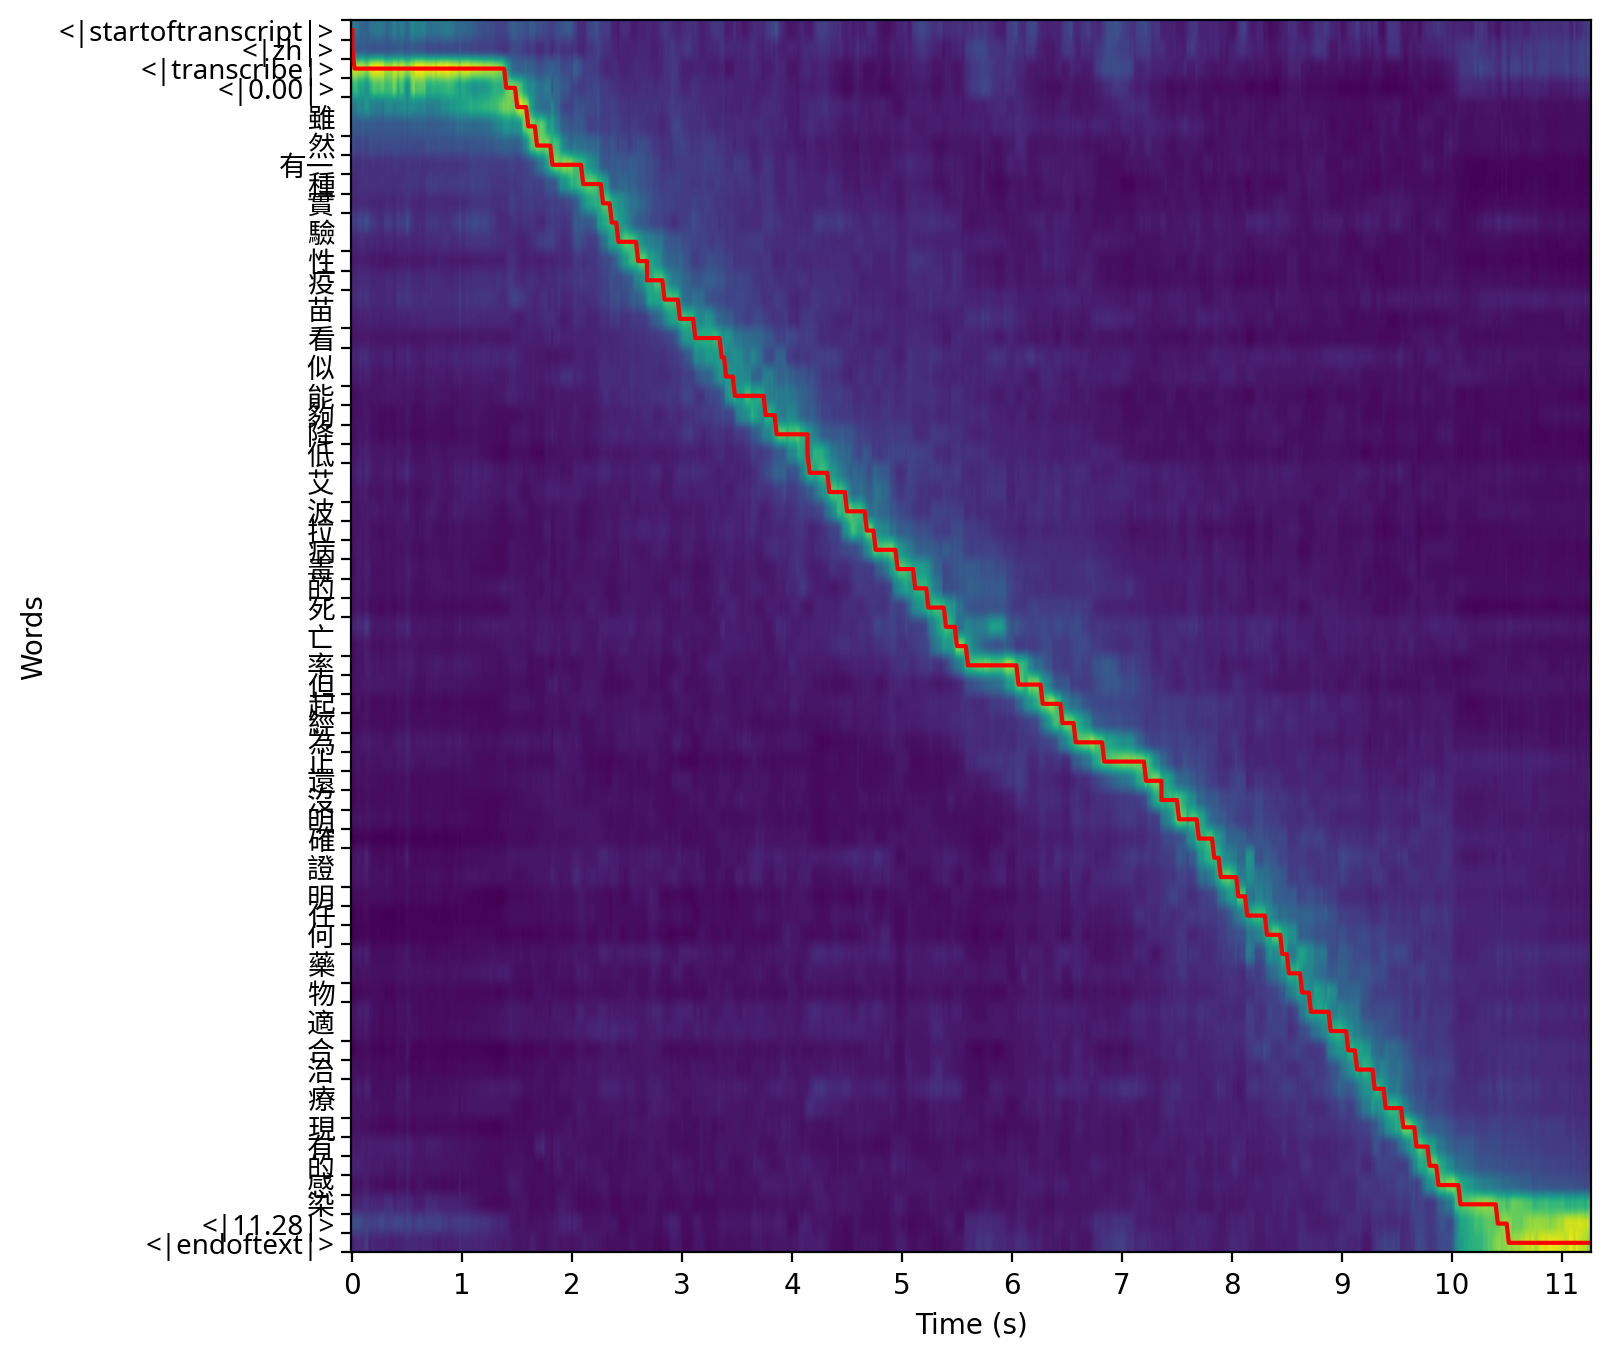

word  begin    end
0     雖   1.50   1.68
1     然   1.68   1.82
2    有一   1.82   2.10
3     種   2.10   2.28
4     實   2.28   2.36
5     驗   2.36   2.60
6     性   2.60   2.68
7     疫   2.68   2.84
8     苗   2.84   3.12
9     看   3.12   3.36
10    似   3.36   3.48
11    能   3.48   3.76
12    夠   3.76   3.86
13    降   3.86   4.14
14    低   4.14   4.16
15    艾   4.16   4.50
16    波   4.50   4.68
17    拉   4.68   4.76
18    病   4.76   4.96
19    毒   4.96   5.12
20    的   5.12   5.24
21    死   5.24   5.40
22    亡   5.40   5.60
23    率   5.60   6.06
24    但   6.06   6.28
25    起   6.28   6.46
26    經   6.46   6.58
27    為   6.58   6.84
28    止   6.84   7.22
29    還   7.22   7.36
30    沒   7.36   7.52
31    明   7.52   7.70
32    確   7.70   7.84
33    證   7.84   8.06
34    明   8.06   8.14
35    任   8.14   8.32
36    何   8.32   8.46
37    藥   8.46   8.64
38    物   8.64   8.72
39    適   8.72   9.06
40    合   9.06   9.14
41    治   9.14   9.30
42    療   9.30   9.56
43    現   9.56   9.68
44    有   9.68   9.80
45    的   9.80   9.88
46    感   9.88  10.08
47    染  10.08  10.42

場景在精緻塔上展示,不同的精緻塔被點亮。


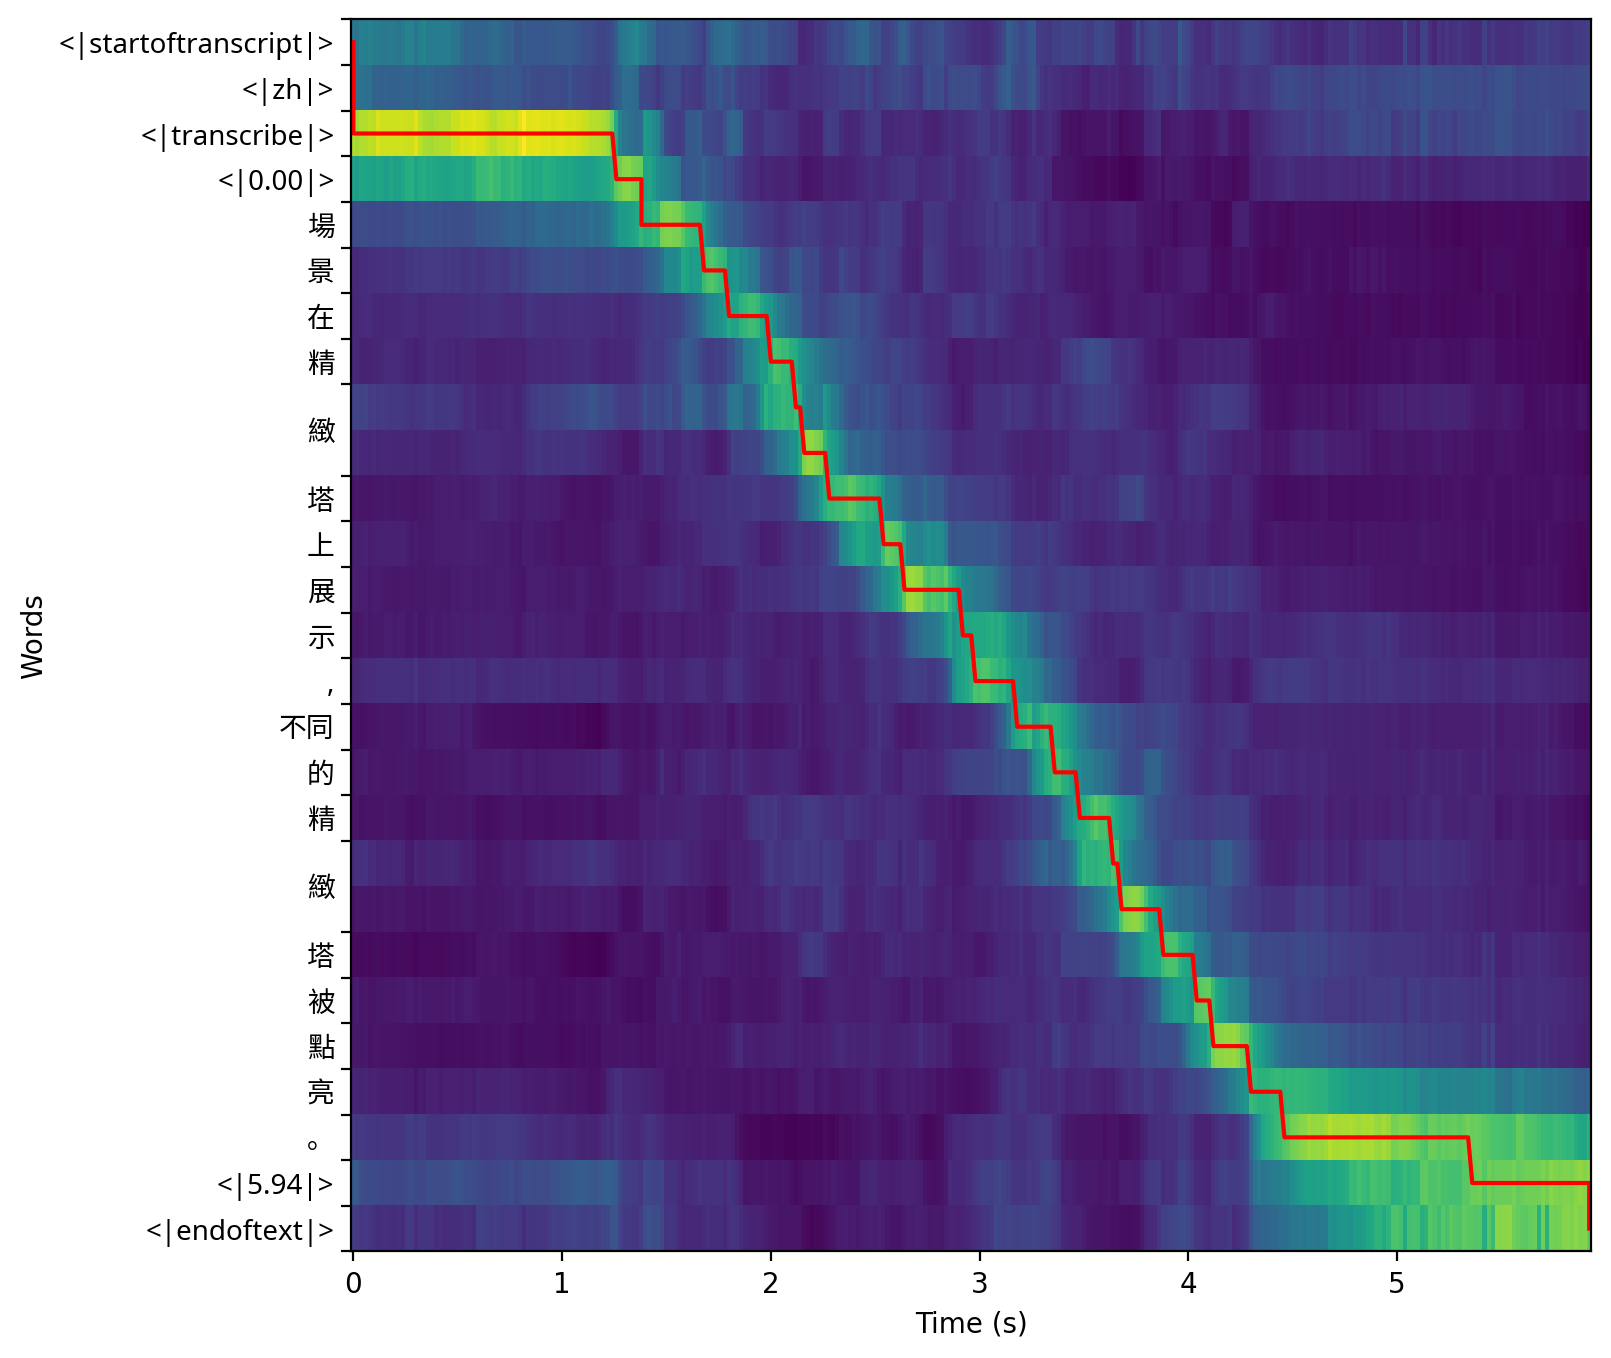

word  begin   end
0     場   1.38  1.68
1     景   1.68  1.80
2     在   1.80  2.00
3     精   2.00  2.12
4     緻   2.12  2.28
5     塔   2.28  2.54
6     上   2.54  2.64
7     展   2.64  2.92
8     示   2.92  2.98
9    不同   3.18  3.36
10    的   3.36  3.48
11    精   3.48  3.64
12    緻   3.64  3.88
13    塔   3.88  4.04
14    被   4.04  4.12
15    點   4.12  4.30
16    亮   4.30  4.46

同理,有了生根签证,你就不必分别向每个生根成员国生起签证,从而解写了时间,金钱和手续。


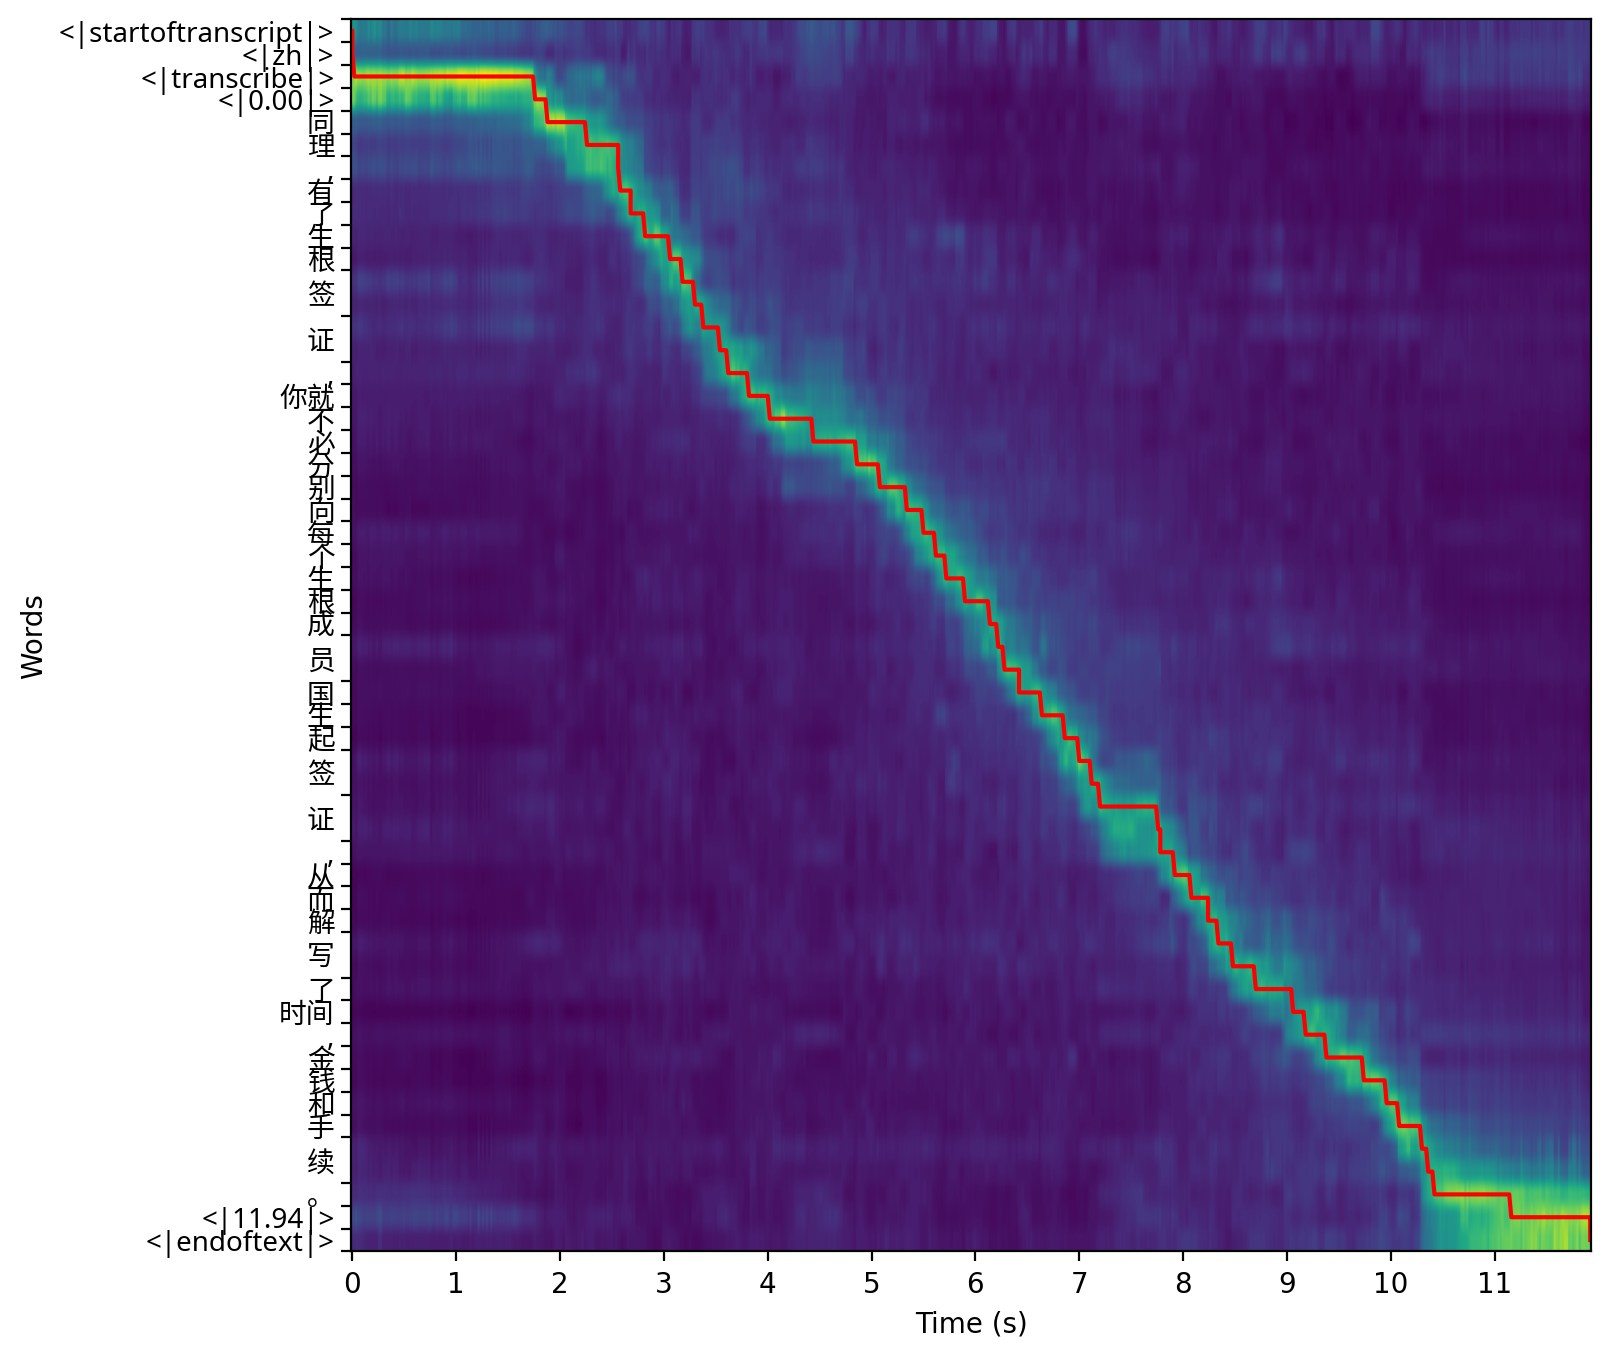

word  begin    end
0     同   1.88   2.26
1     理   2.26   2.56
2     有   2.58   2.68
3     了   2.68   2.82
4     生   2.82   3.06
5     根   3.06   3.18
6     签   3.18   3.38
7     证   3.38   3.62
8    你就   3.82   4.02
9     不   4.02   4.44
10    必   4.44   4.86
11    分   4.86   5.08
12    别   5.08   5.34
13    向   5.34   5.50
14    每   5.50   5.62
15    个   5.62   5.72
16    生   5.72   5.90
17    根   5.90   6.14
18    成   6.14   6.22
19    员   6.22   6.42
20    国   6.42   6.64
21    生   6.64   6.86
22    起   6.86   7.00
23    签   7.00   7.20
24    证   7.20   7.78
25    从   7.92   8.08
26    而   8.08   8.24
27    解   8.24   8.34
28    写   8.34   8.70
29    了   8.70   9.06
30   时间   9.06   9.18
31    金   9.38   9.74
32    钱   9.74   9.96
33    和   9.96  10.08
34    手  10.08  10.30
35    续  10.30  10.42

昨日上午土耳其家企安太普的警察总部发生了一席汽车爆炸事件该事件导致两名警察死亡二十亿元受伤


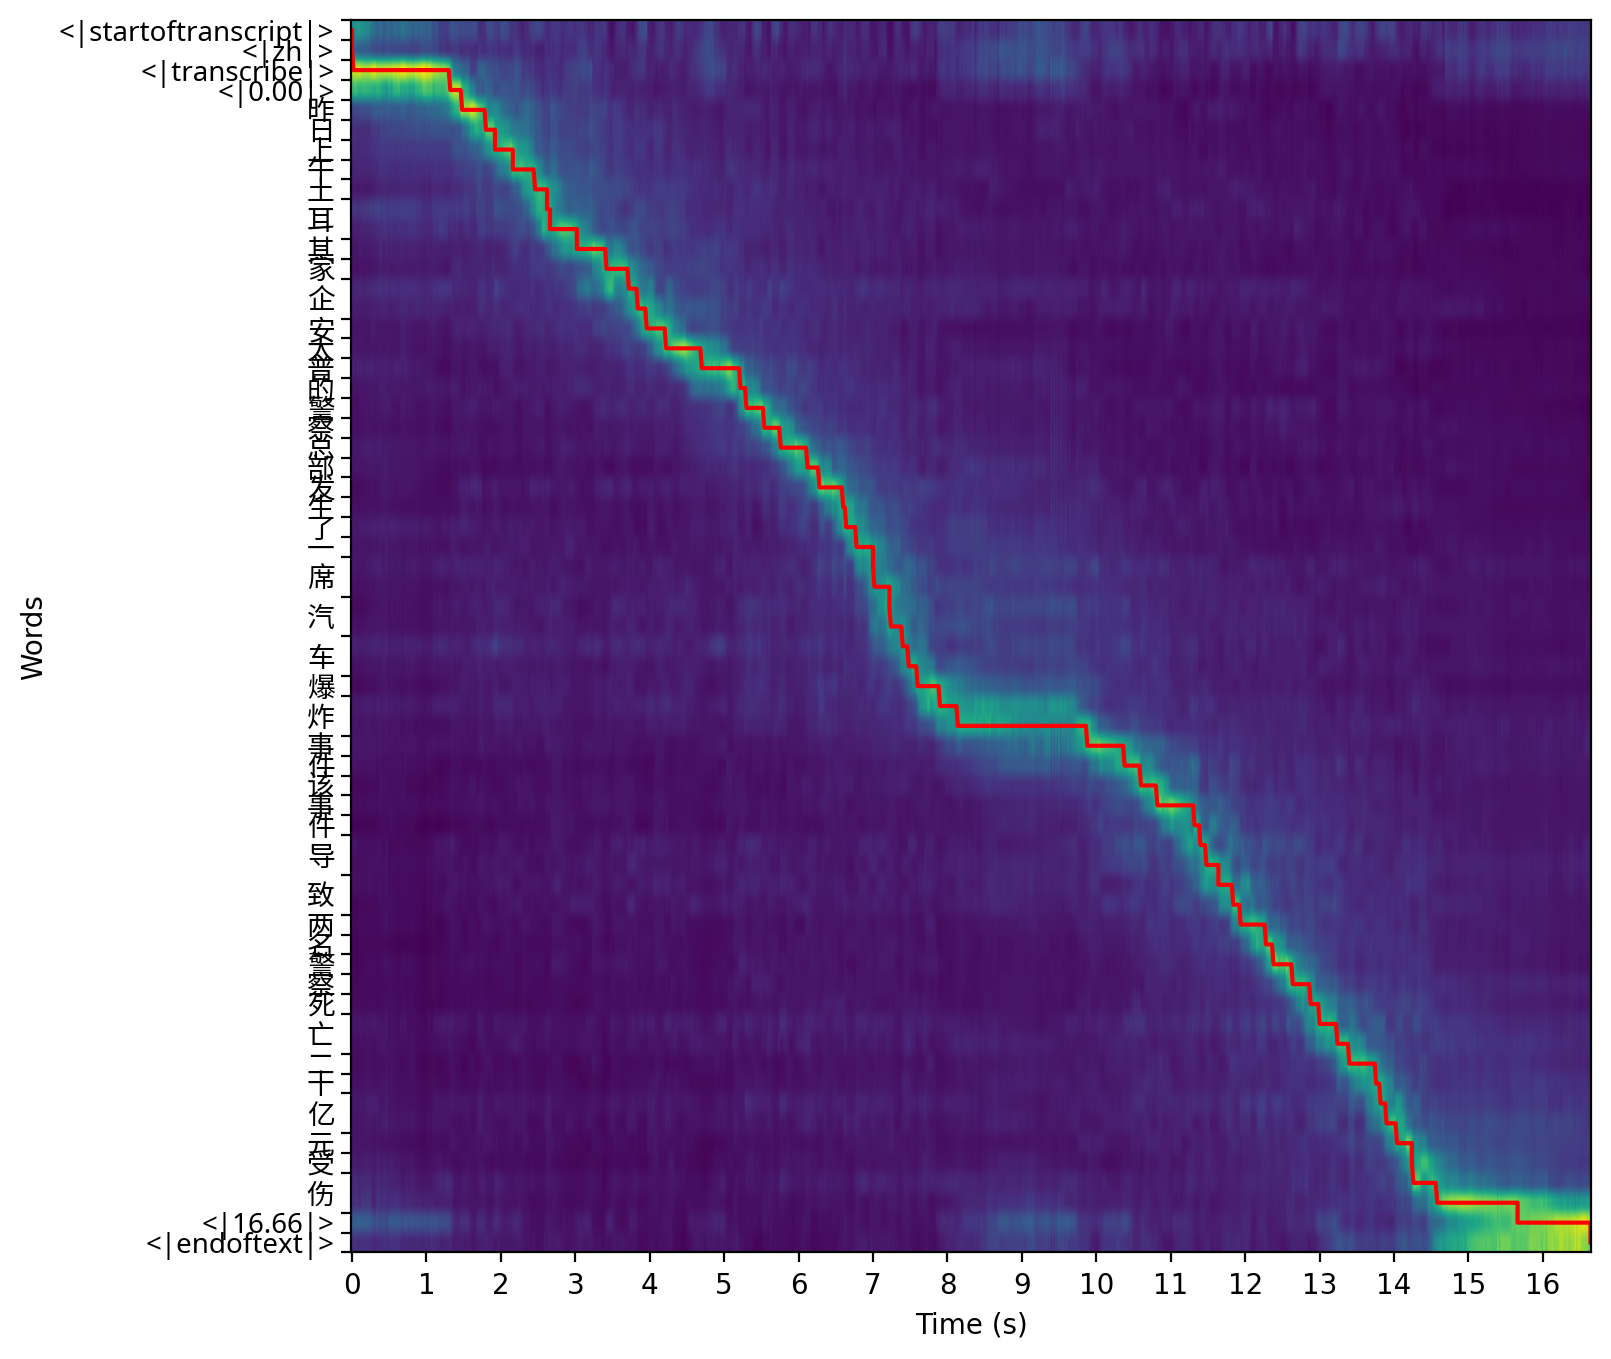

word  begin    end
0     昨   1.48   1.80
1     日   1.80   1.92
2     上   1.92   2.16
3     午   2.16   2.46
4     土   2.46   2.62
5     耳   2.62   3.02
6     其   3.02   3.42
7     家   3.42   3.72
8     企   3.72   3.96
9     安   3.96   4.22
10    太   4.22   4.70
11    普   4.70   5.22
12    的   5.22   5.30
13    警   5.30   5.54
14    察   5.54   5.76
15    总   5.76   6.12
16    部   6.12   6.28
17    发   6.28   6.60
18    生   6.60   6.64
19    了   6.64   6.78
20    一   6.78   7.00
21    席   7.00   7.22
22    汽   7.22   7.40
23    车   7.40   7.60
24    爆   7.60   7.90
25    炸   7.90   9.88
26    事   9.88  10.38
27    件  10.38  10.60
28    该  10.60  10.82
29    事  10.82  11.32
30    件  11.32  11.40
31    导  11.40  11.64
32    致  11.64  11.94
33    两  11.94  12.28
34    名  12.28  12.38
35    警  12.38  12.64
36    察  12.64  12.88
37    死  12.88  13.00
38    亡  13.00  13.40
39    二  13.40  13.76
40    十  13.76  13.82
41    亿  13.82  14.04
42    元  14.04  14.24
43    受  14.24  14.26
44    伤  14.26  15.66

州長辦公室表示 商者中19人是警察


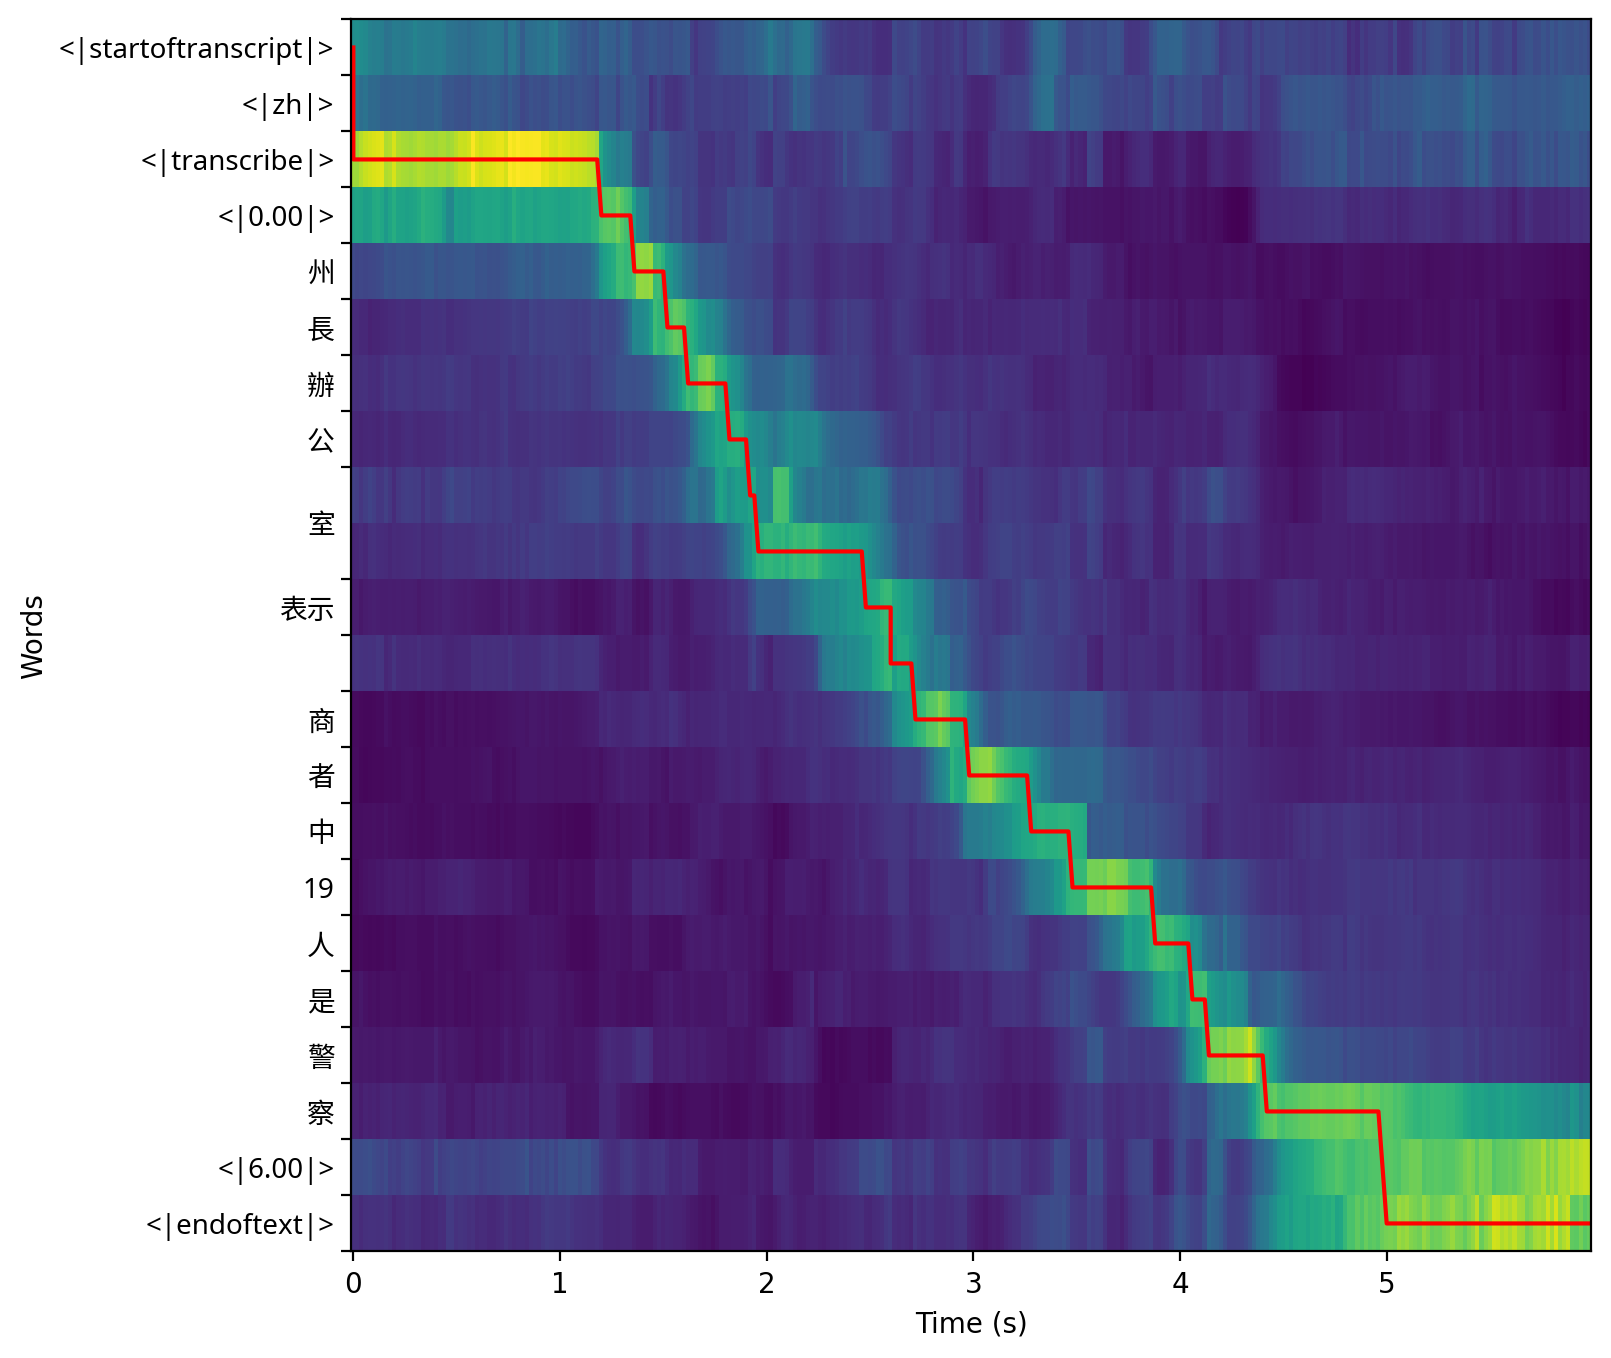

word  begin   end
0     州   1.36  1.52
1     長   1.52  1.62
2     辦   1.62  1.82
3     公   1.82  1.92
4     室   1.92  2.48
5    表示   2.48  2.60
6     商   2.72  2.98
7     者   2.98  3.28
8     中   3.28  3.48
9    19   3.48  3.88
10    人   3.88  4.06
11    是   4.06  4.14
12    警   4.14  4.42
13    察   4.42  4.98

文明是一種由共同生活合作工作的人群社會所共享的單一文化。


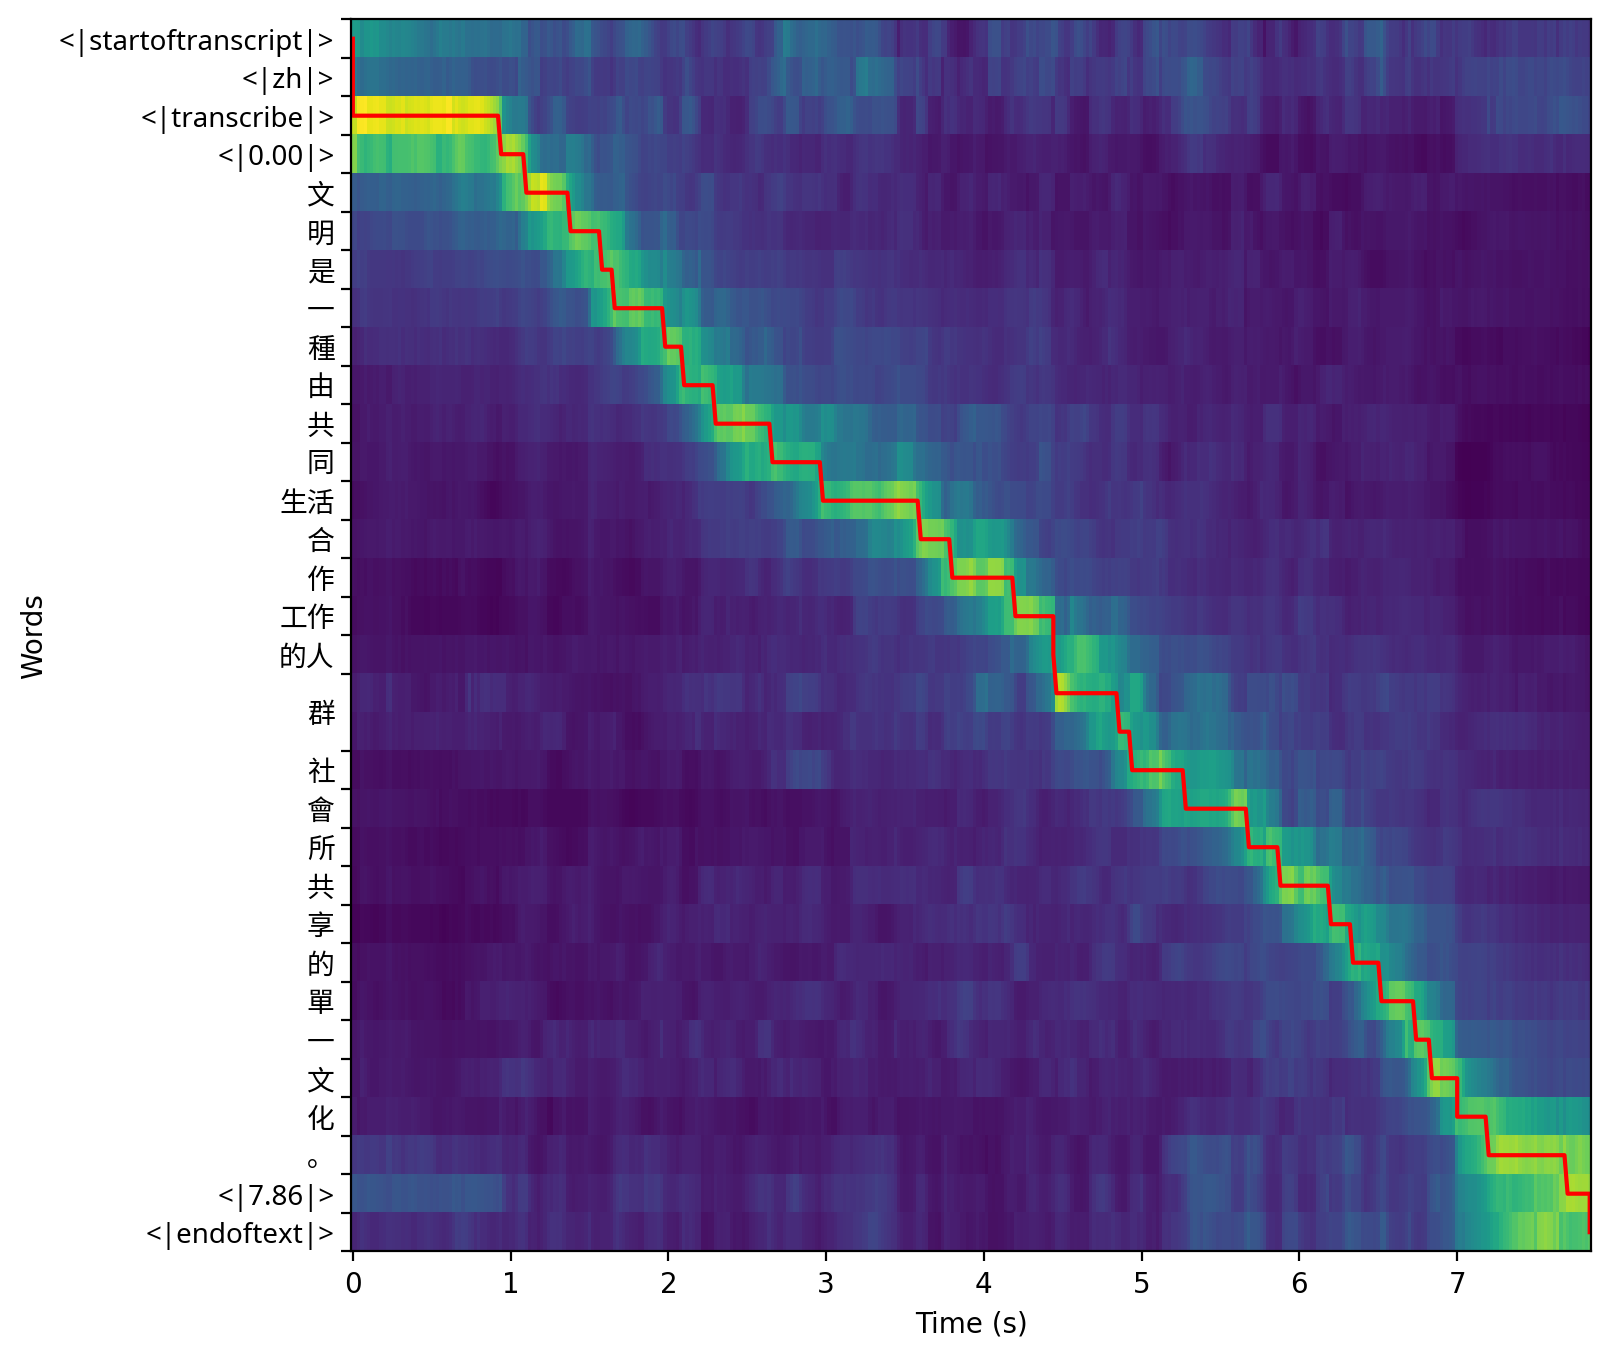

word  begin   end
0     文   1.10  1.38
1     明   1.38  1.58
2     是   1.58  1.66
3     一   1.66  1.98
4     種   1.98  2.10
5     由   2.10  2.30
6     共   2.30  2.66
7     同   2.66  2.98
8    生活   2.98  3.60
9     合   3.60  3.80
10    作   3.80  4.20
11   工作   4.20  4.44
12   的人   4.44  4.46
13    群   4.46  4.94
14    社   4.94  5.28
15    會   5.28  5.68
16    所   5.68  5.88
17    共   5.88  6.20
18    享   6.20  6.34
19    的   6.34  6.52
20    單   6.52  6.74
21    一   6.74  6.84
22    文   6.84  7.00
23    化   7.00  7.20

隨著希臘知識的出來了西方脫離了其希臘哲學和科學根源。


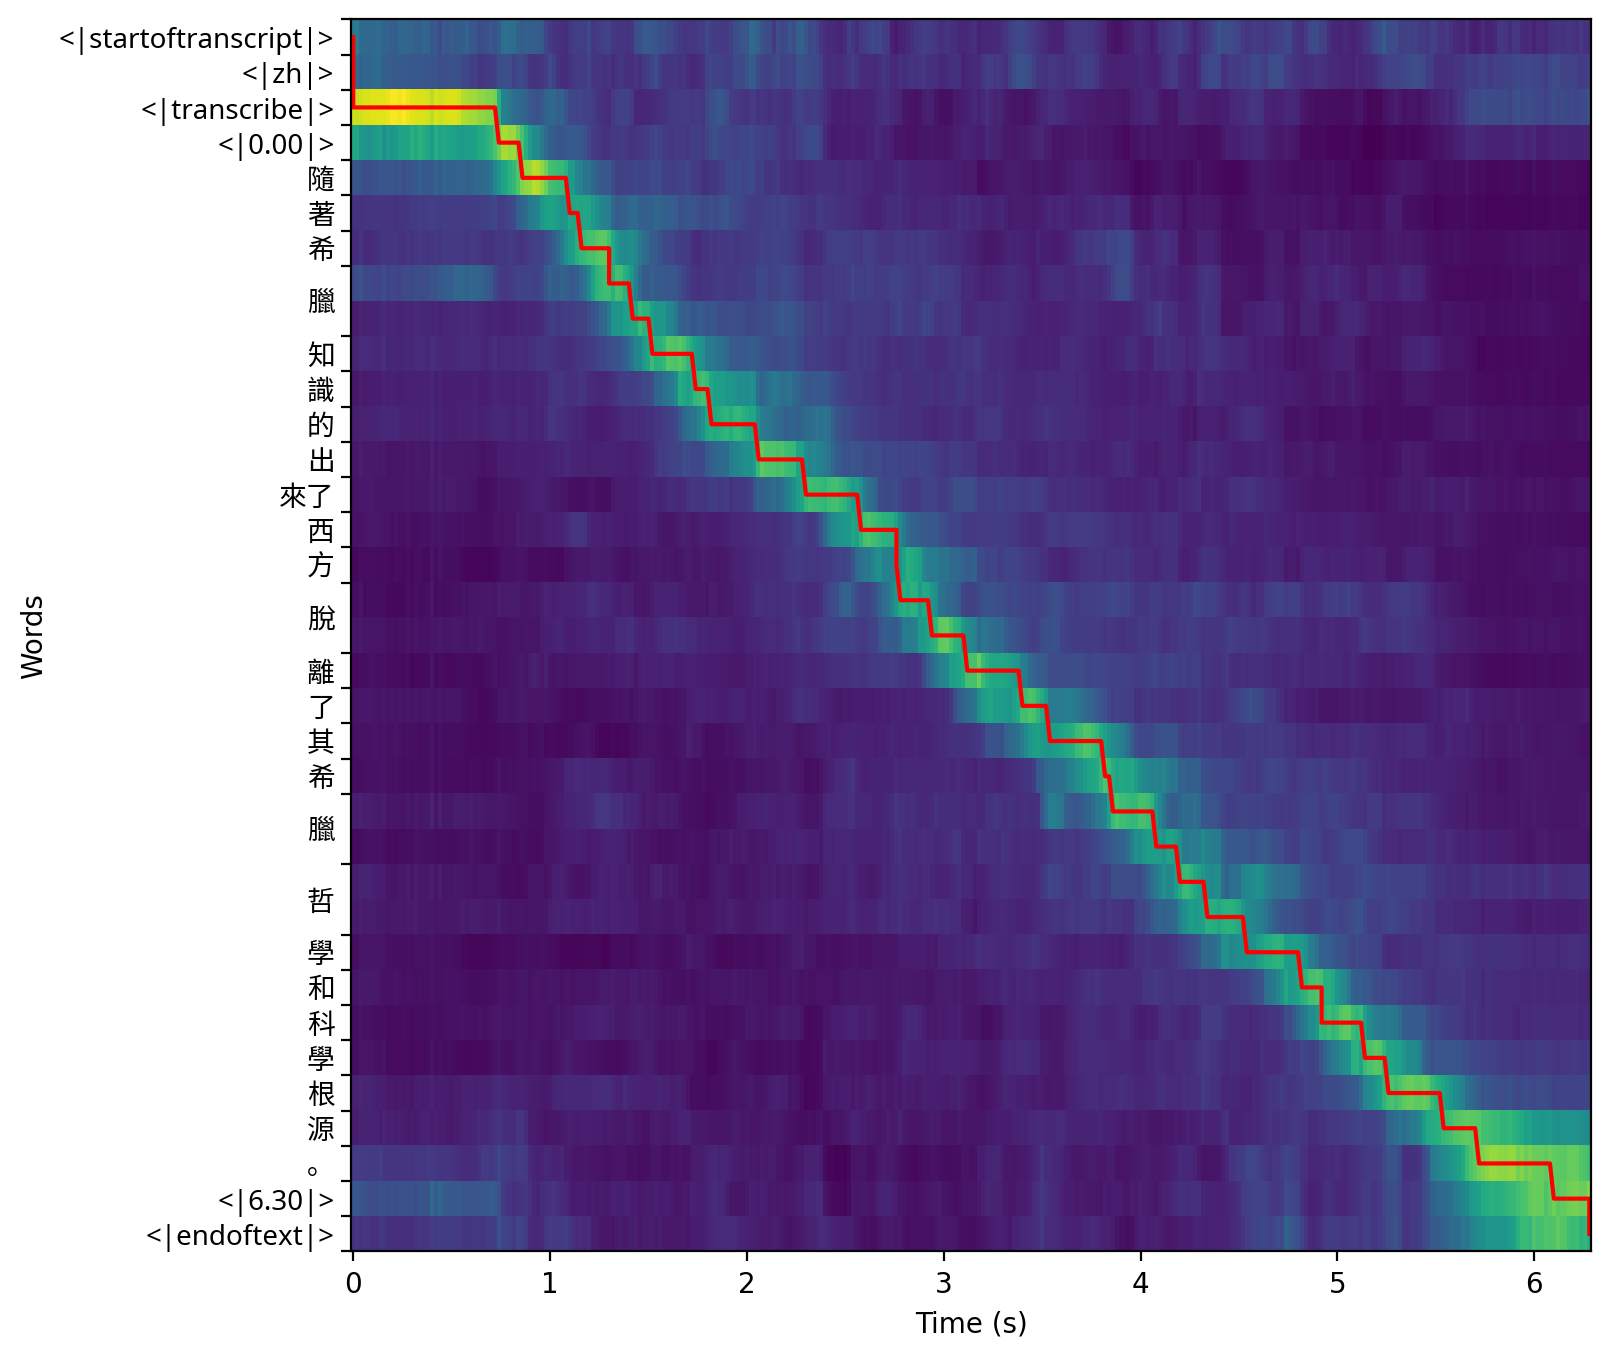

word  begin   end
0     隨   0.86  1.10
1     著   1.10  1.16
2     希   1.16  1.30
3     臘   1.30  1.52
4     知   1.52  1.74
5     識   1.74  1.82
6     的   1.82  2.06
7     出   2.06  2.30
8    來了   2.30  2.58
9     西   2.58  2.76
10    方   2.76  2.78
11    脫   2.78  3.12
12    離   3.12  3.40
13    了   3.40  3.54
14    其   3.54  3.82
15    希   3.82  3.86
16    臘   3.86  4.20
17    哲   4.20  4.54
18    學   4.54  4.82
19    和   4.82  4.92
20    科   4.92  5.14
21    學   5.14  5.26
22    根   5.26  5.54
23    源   5.54  5.72

早年該節目僅在運營依舊的互聯網廣播網站推進Net Radio 上播出推進Net Radio 是一個專注於彈劃廣播的網站


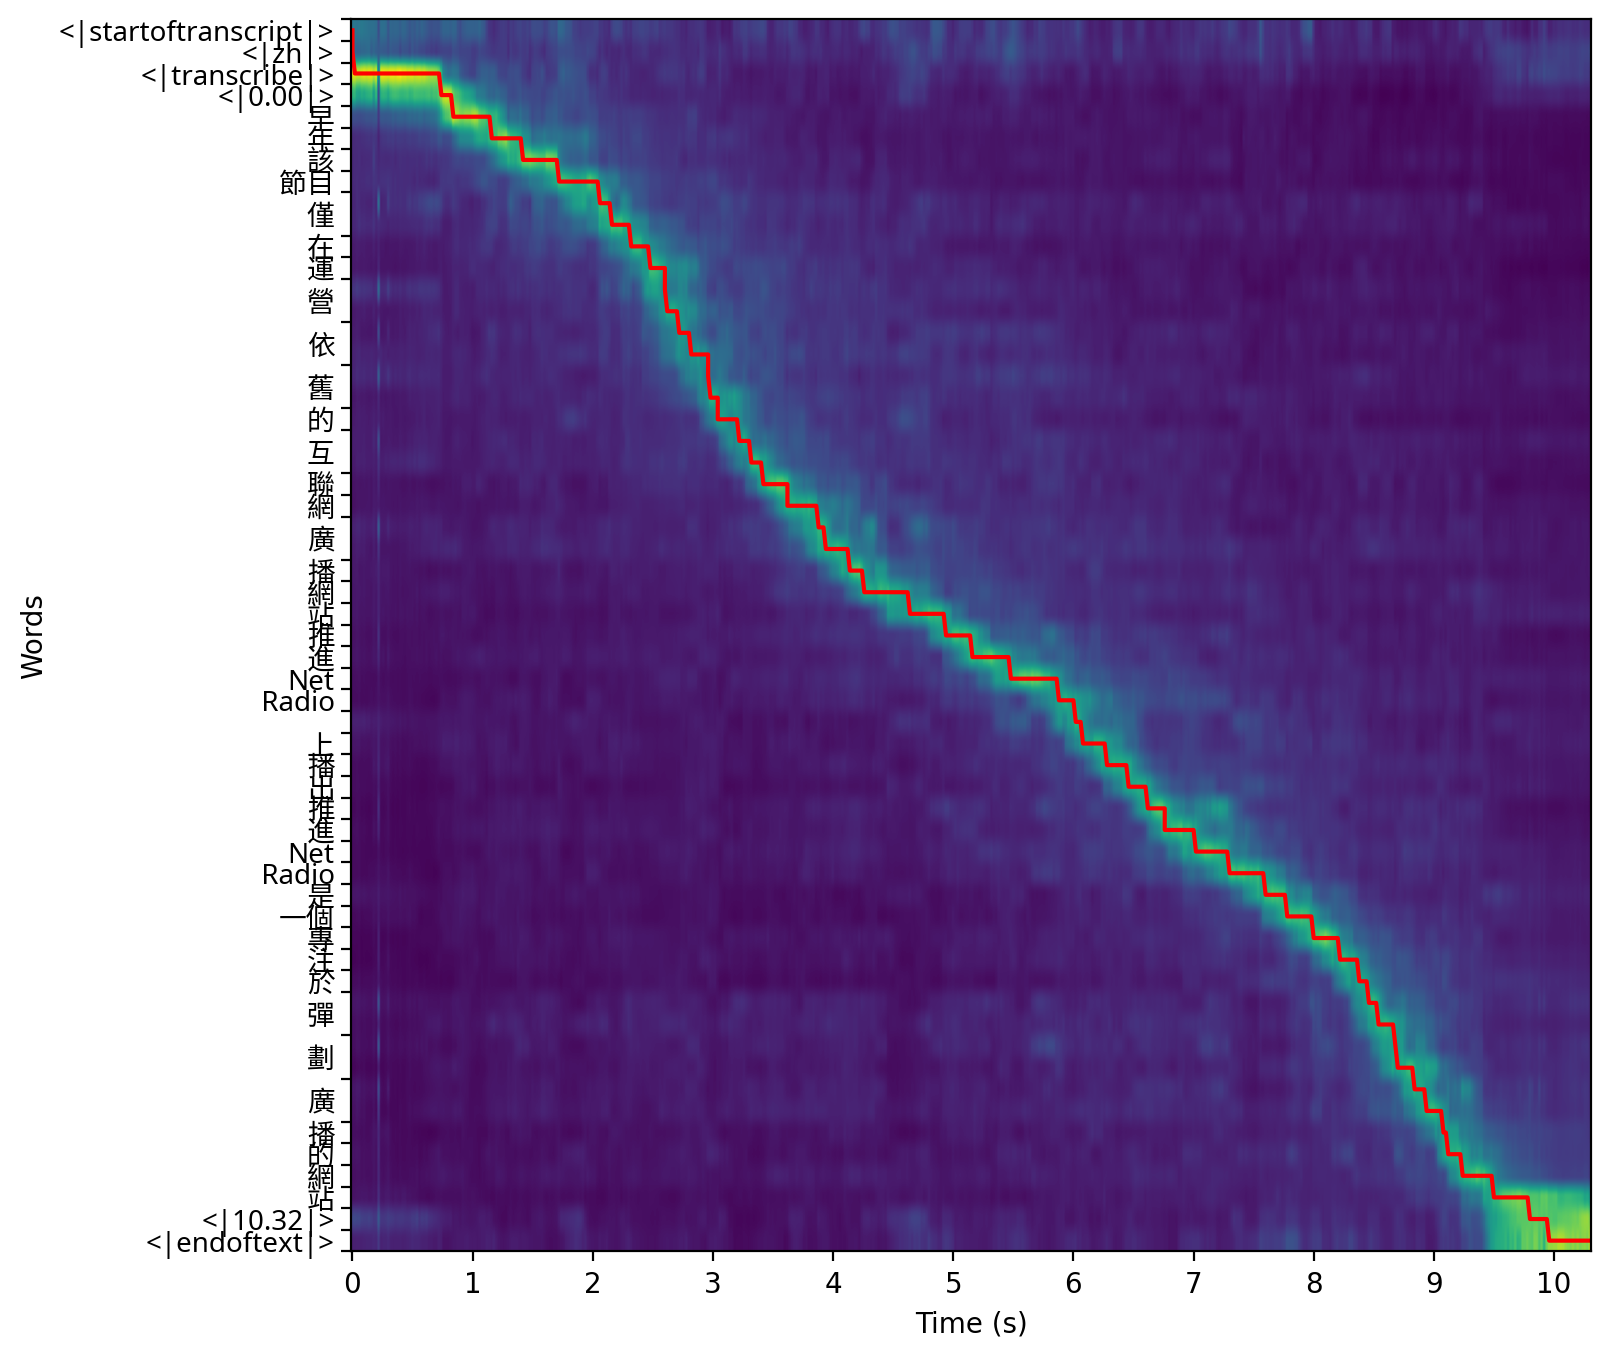

word  begin   end
0        早   0.84  1.16
1        年   1.16  1.42
2        該   1.42  1.72
3       節目   1.72  2.06
4        僅   2.06  2.32
5        在   2.32  2.48
6        運   2.48  2.60
7        營   2.60  2.72
8        依   2.72  2.96
9        舊   2.96  3.04
10       的   3.04  3.22
11       互   3.22  3.42
12       聯   3.42  3.62
13       網   3.62  3.88
14       廣   3.88  4.14
15       播   4.14  4.26
16       網   4.26  4.64
17       站   4.64  4.94
18       推   4.94  5.16
19       進   5.16  5.48
20     Net   5.48  5.88
21   Radio   5.88  6.02
22       上   6.08  6.28
23       播   6.28  6.46
24       出   6.46  6.62
25       推   6.62  6.76
26       進   6.76  7.02
27     Net   7.02  7.30
28   Radio   7.30  7.60
29       是   7.60  7.78
30      一個   7.78  8.00
31       專   8.00  8.22
32       注   8.22  8.38
33       於   8.38  8.46
34       彈   8.46  8.68
35       劃   8.68  8.84
36       廣   8.84  9.08
37       播   9.08  9.12
38       的   9.12  9.24
39       網   9.24  9.50
40       站   9.50  9.80

In [19]:
# for the first 10 examples in the dataset
for (audio, label), transcription in zip(dataset, transcriptions[:10]):
    print(transcription)
  
    duration = len(audio)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)) #.to(DEVICE)
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ) #.to(DEVICE)
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames    
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for label in ax.get_yminorticklabels():
        label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))